# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Circle, FancyBboxPatch
from ipywidgets import Layout, interact, FloatSlider
from IPython.display import clear_output
import imageio
import glob
import os

# Theory

I want to determine the probability of the Moon being just the right size and distance from Earth to allow for total solar eclipses. I just want a rough calculation, so I am going to make a number of simplifying assumption along the way. 

Coincidentally, the Sun just so happens to be 400 times further from the Earth and 400 times larger in diameter than the Moon, leading to their apparent sizes in the sky being roughly the same, which allows for the possibility of total Solar eclipses, where the Moon perfectly covers the Sun as seen from Earth. However, I wonder how great of a coincidence this really is. The size of the Moon itself must have an upper and lower limit. If it is two large it would be considered a planet in a two-body planet system. Conversely, if it is too small it would be considered a Moon at all, rather a satelite. Moreover, there is also an upper and lower limit to the distance that the Moon is able to stably orbit the Earth. This leads to a range of alternative possibilities for the Moons size and distance from Earth, and therefore a range of possible Moons that may not lead to total Solar eclipses. The purpose of this notebook is to investigate the likelihood, under simplifying assumptions, that a Moon randomly drawn from the set of astrophysically possible Moons will be one that leads to total solar eclipses. 

Here is the framework for approaching the problem:
1. Define the limits on the radius 
2. Define the limits on the size of the moon 
3. Determine the combinations of size and distance that lead to a total eclipse 
4. Determine the probability of choosing these configurations from a random sample

The key assumptions I will be making:
1. The Moon follows a circular orbit 
2. The Moons has the same density no matter its mass or radius
3. All distance and radius configurations are equally possible

# Constants and apparent size

In [28]:
r_earth = 6371.0 # km
m_earth = 5.972e24 # kg

r_moon = 1737.1 # km
m_moon = 7.34767309e22 # kg

r_sun = 696340.0 # km
m_sun = 1.989e30 # kg

d_earth_moon = 3633000.0 # perigree, distance for totality in km
d_earth_sun = 149.6e6 # km

density_moon = m_moon / (4/3 * np.pi * r_moon**3) # kg/km^3
density_earth = m_earth / (4/3 * np.pi * r_earth**3) # kg/km^3

hill_ratio = 1/2

In [3]:
def apparent_size(r, d):
    '''
    args: 
        r: radius of object (km)
        d: distance to object (km)
    returns:
        apparent size of object (degrees)
    '''
    return 2 * np.arctan(r / d) * (180 / np.pi) # degrees

In [29]:
apparent_size(r_moon, d_earth_moon) 

0.05479135205469885

In [25]:
print("Apparent size of the Moon from Earth: ", apparent_size(r_moon, d_earth_moon))
print("Apparent size of the Sun from Earth: ", apparent_size(r_sun, d_earth_sun))

Apparent size of the Moon from Earth:  0.5479093868482878
Apparent size of the Sun from Earth:  0.5333830878445046


In [5]:
totality_tolerance = np.abs(apparent_size(r_moon, d_earth_moon) - apparent_size(r_sun, d_earth_sun)) 
print("Totality tolerance: ", totality_tolerance)
print("Totality tolerance in arc minutes: ", totality_tolerance * 60)

Totality tolerance:  0.014526299003783216
Totality tolerance in arc minutes:  0.871577940226993


From this it appears that totality can be defined as having an apparent size that is less than about 2 arc minutes.

# Limits of the mass of a moon

For this we will assume the Earth's Moon can range within the typical sizes of moons found in the solar system. For the lower limit we will take the smallest moon or Mars, Deimos, as the smallest moon-planet ratio. For the upper limit, we can assume that the moon must have a radius less than half the planet, so as not to be considered a binary planet system. 

In [22]:
# mass ratio for Deimos to Mars
m_deimos = 1.4762e15 # kg
m_mars = 6.4171e23 # kg

m_deimos / m_mars * 100

2.3004160757974783e-07

In [7]:
# mass ratio for a moon that is half the radius of the Earth with comparable density to the moon
r_half_earth = r_earth / 2
m_half_earth = 4/3 * np.pi * r_half_earth**3 *  density_moon# kg

m_half_earth / m_earth * 100

7.587319874808962

In [8]:
# lower and upper limit of the mass ratios of a moon to a planet

m_ratio_lower = m_deimos / m_mars # in percentage
m_ratio_upper = m_half_earth / m_earth # in percentage

print("Lower limit of mass ratio: ", m_ratio_lower*100)
print("Upper limit of mass ratio: ", m_ratio_upper*100)

Lower limit of mass ratio:  2.3004160757974783e-07
Upper limit of mass ratio:  7.587319874808962


In [20]:
(m_ratio_lower+m_ratio_upper)/2

0.03793660052425285

Therefore, the lower and upper limit for the mass ratio of a moon to its host planet is $2.3\times 10^{-7}\%$ and $\sim 8\%$ respectively. 

# Limits on distance

The Roche limit depends on the density of the Earth and the Moon. We will assume that the density of the moon is constant to simplify the calculations. 

In [9]:
roche_limit = r_earth * (2*density_earth/density_moon)**(1/3) # km
print("Roche limit for the Earth-Moon system: ", roche_limit, "km")

Roche limit for the Earth-Moon system:  9480.359580360415 km


The Hill radius depends on the mass of the Earth and Moon. However, since the Earth is much larger than the Moon, we can take a single value for the Hill radius, from the mass of Moon. 

$$R_{Roche} = R_{Earth}\cdot \left(2 \frac{\rho_{Earth}}{\rho_{Moon}}\right)^{1/3} \quad \text{and,} \quad R_{Hill} = D_{Earth-Sun} \left(\frac{M_{Earth}}{3M_{Sun}}\right)^{1/3}$$

In [10]:
# the maximum stable radius is taken as 50% of the Hill radius 
hill_limit = hill_ratio * d_earth_sun * (m_earth / (3*m_sun))**(1/3) # km
print("Hill limit for the Earth-Sun system: ", hill_limit, "km")

Hill limit for the Earth-Sun system:  748208.8685465425 km


In [11]:
# the minimum and maximum distances for the Earth-Moon system

print("Minimum distance for the Earth-Moon system: ", roche_limit)
print("Maximum distance for the Earth-Moon system: ", hill_limit)
print("Distance range: ", hill_limit - roche_limit)

Minimum distance for the Earth-Moon system:  9480.359580360415
Maximum distance for the Earth-Moon system:  748208.8685465425
Distance range:  738728.508966182


In [19]:
(roche_limit+hill_limit)/2

378844.6140634515

# Sizes and distances and their apparent sizes

In [12]:
# make a grid in distance and radius ratio 
distance = np.linspace(roche_limit, hill_limit, num=10000)
mass_ratio = np.linspace(m_ratio_lower, m_ratio_upper, num=10000)

radii =  (3*(mass_ratio*m_earth) / (4 * np.pi * density_moon))**(1/3)


D, R = np.meshgrid(distance, radii)

apparent_sizes = apparent_size(R, D) 

In [13]:
apparent_sun_size = apparent_size(r_sun, d_earth_sun)
apparent_sun_size_lower = apparent_sun_size - totality_tolerance
apparent_sun_size_upper = apparent_sun_size + totality_tolerance


In [30]:
print(apparent_sun_size_lower, apparent_sun_size_upper)

0.5188567888407214 0.5479093868482878


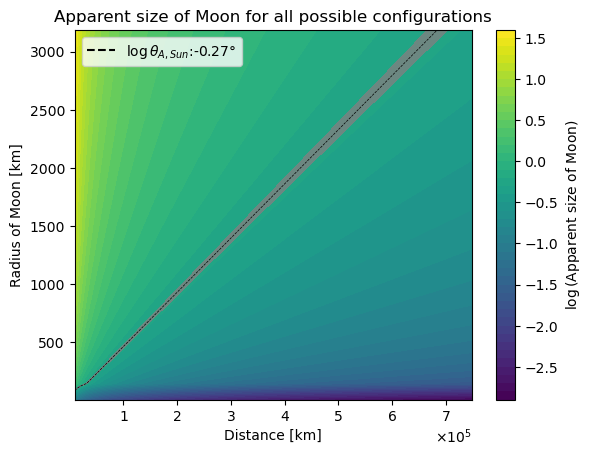

In [15]:
# contour plot for the distances and radii, colored by the apparent size of the moon

c = plt.contourf(D, R, np.log10(apparent_sizes), levels=50, cmap='viridis')
cbar = plt.colorbar(c)
cbar.set_label(r'$\log$(Apparent size of Moon)')
plt.xlabel('Distance [km]')
plt.ylabel('Radius of Moon [km]')
plt.title("Apparent size of Moon for all possible configurations")
# plt.xscale('log')
# plt.yscale('log')  
# draw a constant contour line at the apparent size of the sun
plt.contour(D, R, np.log10(apparent_sizes), levels=[np.log10(apparent_sun_size)], colors='black', linewidths=0.5)
line = plt.plot([], [], 'k--', label=r'$\log\theta_{A,Sun}$:' + f'{np.log10(apparent_sun_size):.2f}$\degree$')
levels_for_filled_band = [np.log10(apparent_sun_size_lower), np.log10(apparent_sun_size_upper)]
plt.contourf(D, R, np.log10(apparent_sizes), levels=levels_for_filled_band, colors='gray', alpha=0.8)

ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Use mathematical text for scientific notation
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  
plt.legend(loc='upper left', fontsize='medium')
# plt.savefig('apparent_size_log.png')
plt.show()

In [14]:
eclipses = np.abs(apparent_sizes - apparent_sun_size) <= totality_tolerance
np.sum(eclipses) /apparent_sizes.size * 100


3.7868619999999997

# Monte-Carlo Simulation for the probability of a Moon that has a total eclipse

In [15]:
# Monte Carlo Simulation for Estimating Probability
def mcmc_sampler(num_samples=1000):
    count = 0

    for _ in range(num_samples):
        # Randomly select a sample
        d_sample = np.random.choice(distance)
        r_sample = np.random.choice(radii)
        sample_apparent_size = apparent_size(r_sample, d_sample)
        
        # Check if the sample falls within the eclipse zone
        if np.abs(sample_apparent_size - apparent_sun_size) <= totality_tolerance:
            count += 1
            
    # Calculate probability
    probability = count / num_samples * 100
    return probability

# Estimate the probability
probability = mcmc_sampler()
print(f"Estimated Probability: {probability}")

Estimated Probability: 3.1


In [16]:
# %matplotlib widget

# def update_plot(moon_distance=d_earth_moon, moon_radius=r_moon):
#     fig, ax = plt.subplots(figsize=(5, 5))
    
#     # Sun
#     sun_size = apparent_size(r_sun, d_earth_sun)
#     sun = Circle((0.5, 0.5), sun_size / 5, color='yellow', label=f'Sun: {sun_size:.2f}°')
    
#     # Moon
#     moon_size = apparent_size(moon_radius, moon_distance)
#     moon = Circle((0.5, 0.5), moon_size / 5, color='grey', alpha=0.8, label=f'Moon: {moon_size:.2f}°')
    
#     ax.add_artist(sun)
#     ax.add_artist(moon)
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 1)
#     ax.axis('off')
#     plt.legend(loc='upper left')
#     plt.show()

# # Define your sliders with a custom layout for increased width
# moon_distance_slider = FloatSlider(
#     min=roche_limit, 
#     max=hill_limit, 
#     step=1000, 
#     value=d_earth_moon, 
#     description='Moon Distance (km):',
#     layout=Layout(width='500px', description_width='initial')  # Adjust the width as needed
# )

# moon_radius_slider = FloatSlider(
#     min=radii.min(), 
#     max=radii.max(), 
#     step=10, 
#     value=r_moon, 
#     description='Moon Radius (km):',
#     layout=Layout(width='500px', description_width='initial') # Adjust the width as needed
# )
# interact(update_plot, 
#          moon_distance=moon_distance_slider,
#          moon_radius=moon_radius_slider)

In [87]:
# [x,y] array of random positions between 0 and 1
random_positions = np.random.rand(60, 2)
random_positions

array([[0.96968568, 0.45754118],
       [0.20981558, 0.15863859],
       [0.42159425, 0.24912912],
       [0.28162798, 0.69026077],
       [0.26832243, 0.36396356],
       [0.58691506, 0.26737366],
       [0.43362286, 0.68921255],
       [0.72900691, 0.55634368],
       [0.4992751 , 0.91883486],
       [0.17958179, 0.44577304],
       [0.57911366, 0.5691578 ],
       [0.32460152, 0.76787569],
       [0.60792381, 0.38187003],
       [0.095454  , 0.65973249],
       [0.57195441, 0.11896389],
       [0.83208091, 0.45108541],
       [0.68844181, 0.81136631],
       [0.1868823 , 0.26028106],
       [0.44468552, 0.1269026 ],
       [0.90785868, 0.82949837],
       [0.75525759, 0.83659826],
       [0.95200998, 0.92308216],
       [0.14732351, 0.19107547],
       [0.49374771, 0.23805763],
       [0.02168911, 0.7013212 ],
       [0.04723757, 0.17981478],
       [0.09217263, 0.09521672],
       [0.08269457, 0.85033955],
       [0.04182681, 0.61486653],
       [0.02418961, 0.3058893 ],
       [0.

In [174]:
def plot_apparent_size_with_legend(moon_distance, moon_radius):
    moon_size = apparent_size(moon_radius, moon_distance)
    sun_size = apparent_sun_size # Assuming this is a predefined constant

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    sun = Circle((0.5, 0.5), sun_size / 10, color='orange')
    moon = Circle((0.5, 0.5), moon_size / 10, color='lightgrey', alpha=0.8, label=f'Sun Apparent Size: {sun_size:.2f}°\nMoon Apparent Size: {moon_size:.2f}°\nMoon Distance: {moon_distance:.0f} km\nMoon Radius: {moon_radius:.0f} km')

    for i,j in random_positions:
        star = Circle((i, j), 0.001, color='white')
        ax.add_artist(star)

    ax.add_artist(sun)
    ax.add_artist(moon)

    # adding a distance meaure to the bottom of the plot
    moon_distance_scaled = 0.97*(moon_distance / hill_limit)  
    bracket_width = moon_distance_scaled  
    bracket_height = 0.05  
    bracket_position = (0.01, 0.01)  

    bracket = FancyBboxPatch((bracket_position[0], bracket_position[1] - bracket_height / 2),
                             bracket_width, bracket_height,
                             boxstyle="square,pad=0",
                             edgecolor="white", facecolor="none", lw=2)
    ax.add_patch(bracket)
    
    # distance bracket
    ax.plot([bracket_position[0], bracket_position[0]], [bracket_position[1] - bracket_height, bracket_position[1] + bracket_height], color="white", lw=2)
    ax.plot([bracket_position[0] + bracket_width, bracket_position[0] + bracket_width], [bracket_position[1] - bracket_height, bracket_position[1] + bracket_height], color="white", lw=2)

    # add a legend to the plot with white text
    legend = ax.legend(loc='upper left', fontsize='small', handlelength=0, handletextpad=0, fancybox=True)
    frame = legend.get_frame()
    frame.set_facecolor('black')  
    frame.set_edgecolor('white')
    for item in legend.legendHandles:
        item.set_visible(False)  
    plt.setp(legend.get_texts(), color='white') 
    # plt.show()


/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_28247/3775517733.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in legend.legendHandles:


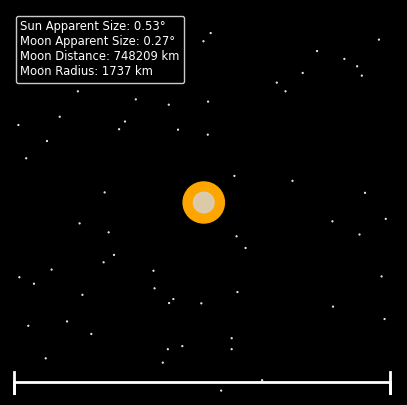

In [173]:
plot_apparent_size_with_legend(moon_distance=hill_limit, moon_radius=1737.4)

In [128]:
# used for sorting properly
def int_to_char(i):
    if 0 <= i <= 25:
        return chr(97 + i)  
    else:
        return None

In [175]:
def save_plot_images():
    moon_distances = np.flip(np.linspace(roche_limit, hill_limit, 10))
    moon_radii = np.linspace(radii.min(), radii.max(), 20)

    for i, moon_distance in enumerate(moon_distances):
        letter1 = int_to_char(i)
        for j, moon_radius in enumerate(moon_radii):
            letter2 = int_to_char(j)
            plot_apparent_size_with_legend(moon_distance=moon_distance, moon_radius=moon_radius)
            plt.savefig(f'plots/plot_{letter1}_{letter2}.png')  
            plt.close()
            clear_output(wait=True)  

save_plot_images()

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_28247/2807822670.py:48: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in legend.legendHandles:


# Create a GIF for this demo

In [176]:
def create_gif(image_pattern, output_path='output.gif', duration=0.01):
    images = []
    for filename in sorted(glob.glob(image_pattern)):  
        images.append(imageio.imread(filename))
    imageio.mimsave(output_path, images, format='GIF', fps=20)

# Use the function to create a GIF from the saved images
create_gif('plots/plot_*.png', 'moon_sun_size.gif', duration=0.1)

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_28247/89553274.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))
